## Predicting the stock market

I'll be using historical data on the price of the S&P500 Index to make predictions about future prices. I'll train the model with data from 1950-2012 and try to make predictions from 2013-2015.

In [56]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [57]:
data = pd.read_csv('sphist.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16590 entries, 0 to 16589
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       16590 non-null  object 
 1   Open       16590 non-null  float64
 2   High       16590 non-null  float64
 3   Low        16590 non-null  float64
 4   Close      16590 non-null  float64
 5   Volume     16590 non-null  float64
 6   Adj Close  16590 non-null  float64
dtypes: float64(6), object(1)
memory usage: 907.4+ KB


In [58]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date',ascending = True, ignore_index=True) 

In [59]:
lowest_price_per_yr = {}
highest_price_per_yr = {}

for year in data['Date'].dt.year:
    if year in lowest_price_per_yr:
        pass
    else:
        lowest_price_per_yr[year] = data[data['Date'].dt.year==year].Close.min()
        
for year in data['Date'].dt.year:
    if year in highest_price_per_yr:
        pass
    else:
        highest_price_per_yr[year] = data[data['Date'].dt.year==year].Close.max() 

## Generating Indicators

In [60]:
# 5-day Average Price
data['day_5'] = data.Close.rolling(5,closed='left').mean()

# 30-day Average Price
data['day_30'] = data.Close.rolling(30,closed='left').mean()

# 360-day Average Price
data['day_365'] = data.Close.rolling(250,closed='left').mean()

# 5-day average price / 365-day average price
data['ratio_5/365'] = data['day_5']/data['day_365']

# 5-day Standard deviation
data['std_day_5'] = data.Close.rolling(5,closed='left').std()

# 365-day Standard deviation
data['std_day_365'] = data.Close.rolling(250,closed='left').std()

# 5-day standard deviation / 365-day standard deviation
data['std_5/365'] = data['std_day_5']/data['std_day_365']

## Splitting Up the Data

In [69]:
df = data.dropna(axis=0)
train = df[df["Date"] < datetime(year=2013, month=1, day=1)]
test = df[df["Date"] >= datetime(year=2013, month=1, day=1)]

## Testing Predictions

In [62]:
features = df.columns.drop(['Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close', 'Date'])
target = 'Close'

lr = LinearRegression()
lr.fit(train[features],train[target])

predictions = lr.predict(test[features])
mae = mean_absolute_error(test[target],predictions)
rmse = np.sqrt(mean_squared_error(test[target],predictions))

print('MAE:',mae, '\nRMSE: ',rmse)

MAE: 16.163923488869365 
RMSE:  22.20931880153775


In [63]:
def Num_Holidays(x):
    date = x.date()
    this_first = date.replace(day=1)
    prev_last = this_first - timedelta(days=1)
    prev_first = prev_last.replace(day=1)
    cal = USFederalHolidayCalendar()
    h = cal.holidays(start='1950-01-03', end='2015-12-07').to_pydatetime()
    d = pd.date_range(prev_first, prev_last)
    num = 0
    for holiday in h:
        if holiday in d:
            num += 1
    return num

In [64]:
def l_yr_lowest_price(x,price):
    value = x.date().year
    return lowest_price_per_yr[value]/price

def l_yr_highest_price(x,price):
    value = x.date().year
    return highest_price_per_yr[value]/price

In [65]:
# The average volume over the past five days.
data['vol_5'] = data.Volume.rolling(5,closed='left').mean()

# The average volume over the past year.
data['vol_365'] = data.Volume.rolling(250,closed='left').mean()

# The ratio between the average volume for the past five days, and the average volume for the past year.
data['vol_5/365'] = data['vol_5']/data['vol_365']

# The standard deviation of the average volume over the past five days.
data['std_vol_5'] = data.Volume.rolling(5,closed='left').std()

# The standard deviation of the average volume over the past year.
data['std_vol_365'] = data.Volume.rolling(250,closed='left').std()

# The ratio between the standard deviation of the average volume for the past five days, 
# and the standard deviation of the average volume for the past year.
data['std_vol_5/365'] = data['std_vol_5']/data['std_vol_365']

# The year component of the date.
data['year'] = data['Date'].dt.year

# The ratio between the lowest price in the past year and the current price.
data['lowest_pr/current_pr'] = data.apply(lambda row: l_yr_lowest_price(row['Date'],row['Close']), axis=1)

# The ratio between the highest price in the past year and the current price.
data['highest_pr/current_pr'] = data.apply(lambda row: l_yr_highest_price(row['Date'],row['Close']), axis=1)

# The month component of the date.
data['Month'] = data['Date'].dt.month

# The day of week.
data['Weekday'] = data['Date'].dt.weekday

# The day component of the date.
data['day'] = data['Date'].dt.day

# The number of holidays in the prior month.
data['last_month_holidays'] = data.apply(lambda row: Num_Holidays(row['Date']), axis=1)

In [71]:
df2 = data.dropna(axis=0)
train = df2[df2["Date"] < datetime(year=2013, month=1, day=1)]
test = df2[df2["Date"] >= datetime(year=2013, month=1, day=1)]

features = df2.columns.drop(['Close', 'High', 'Low', 'Open', 'Volume', 'Adj Close', 'Date'])
target = 'Close'

lr = LinearRegression()
lr.fit(train[features],train[target])

predictions = lr.predict(test[features])
mae = mean_absolute_error(test[target],predictions)
rmse = np.sqrt(mean_squared_error(test[target],predictions))

print('MAE:',mae, '\nRMSE: ',rmse)

MAE: 16.33929850522917 
RMSE:  22.259794730291695


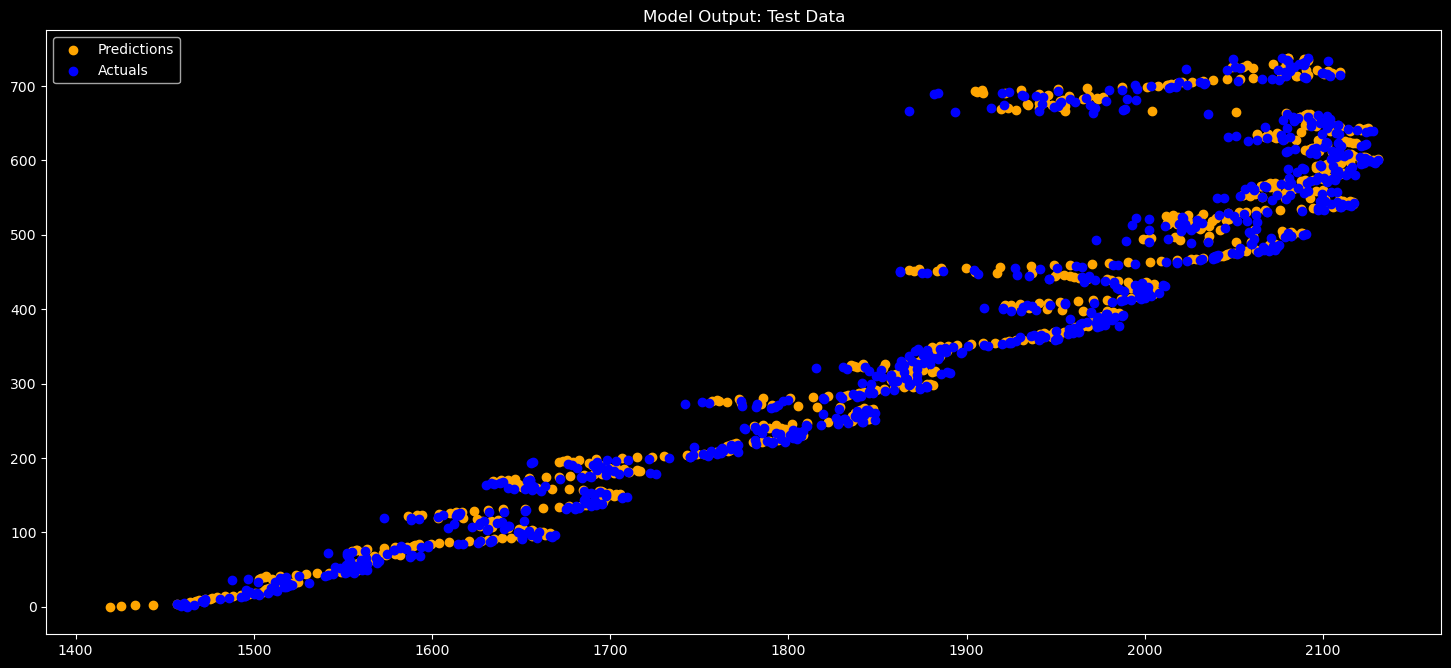

In [67]:
# Plot
plt.style.use('dark_background')
plt.rcParams.update({'figure.figsize':(18,8), 'figure.dpi':100})
plt.scatter(predictions, range(len(predictions)), label='Predictions', color='Orange')
plt.scatter(test[target], range(len(test[target])), label='Actuals', color='Blue')

# Plot
plt.title('Model Output: Test Data')
plt.legend()
plt.show()

In [68]:
print(pd.DataFrame({'Predicted': predictions, 'Trained: Actual': test[target]}))

         Predicted  Trained: Actual
15851  1419.135505      1462.420044
15852  1425.505003      1459.369995
15853  1433.459067      1466.469971
15854  1443.482795      1461.890015
15855  1456.992309      1457.150024
...            ...              ...
16585  2088.942732      2102.629883
16586  2091.852031      2079.510010
16587  2089.557285      2049.620117
16588  2080.173478      2091.689941
16589  2080.402683      2077.070068

[739 rows x 2 columns]
